In [ ]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers
import pandas as pd
from torch.utils.data import Dataset,DataLoader, random_split
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torchvision.transforms import v2, Compose, ToTensor, Resize, transforms
from torch import nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torchvision import models

In [ ]:
print("GPU available: ", tf.config.list_physical_devices('GPU'))
from google.colab import drive
drive.mount('/content/drive')

GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mounted at /content/drive


In [ ]:
SEQ_LEN = 10
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.001
LEFT_CONTEXT = 5

# These are the input image parameters.
HEIGHT = 224
WIDTH = 224
CHANNELS = 3 # RGB

# The parameters of the LSTM that keeps the model state.
RNN_SIZE = 32
RNN_PROJ = 32

# Our training data follows the "interpolated.csv" format from Ross Wightman's scripts.
CSV_HEADER = "index,timestamp,width,height,frame_id,filename,angle,torque,speed,lat,long,alt".split(",")
OUTPUTS = CSV_HEADER[-6:-3] # angle,torque,speed
OUTPUT_DIM = len(OUTPUTS) # predict all features: steering angle, torque and vehicle speed

In [ ]:
# import shutil
# from pathlib import Path

# # define file path
# root_path = Path("/content/drive/MyDrive")
# zip_file = root_path / "center.zip"  # assume .zip fle under this dir
# extract_dir = root_path / "center"   # to ..zip until unzip

# # unpack
# shutil.unpack_archive(zip_file, extract_dir)

# print(f"has released {zip_file} unzip to {extract_dir}")


In [ ]:
# filepath  ="/content/drive/MyDrive/combined_interpolated.csv"
# #read initial csv and extract center camera data，save to the save_path = center_camera_data.csv

# df = pd.read_csv(filepath)

# df_centercamera = df[df['frame_id']=='center_camera']
# df_centercamera.head()
# center_camera = df_centercamera[['filename', 'angle', 'torque', 'speed']]
# #check first 5 rows from center_camera
# center_camera.head()
# # Define the path where you want to save the file
# # save_path = '/home/fengxiang/udacity-driving-reader/udacity-driving-reader/center_camera_data.csv'
# save_path = "/content/drive/MyDrive/center_camera_data.csv"
# # # Save the DataFrame to a CSV file
# center_camera.to_csv(save_path, index=False)
# # center_camera.to_numpy(dtype= tf.float32)




In [ ]:
# gc_save_path = "gs://dml-project-test1/center_camera_data.csv"
# gc_root_path = "gs://dml-project-test1"


In [ ]:
# Extract data and save data to csv, only need do once
import os
import pandas as pd
import numpy as np



# read main csv and struct a dic {filename: [angle, torque, speed]}
def load_main_table(csv_filepath):
    df = pd.read_csv(csv_filepath)
    # assume filename, angle, torque, speed columns are exist
    data_dict = {row['filename']: np.array([row['angle'], row['torque'], row['speed']], dtype=np.float32)
                 for _, row in df.iterrows()}
    return data_dict

# save data to CSV
def save_to_csv(data_seq, csv_filename):
    with open(csv_filename, 'w') as f:
        f.write('filename,angle,torque,speed\n')
        for img_path, target in data_seq:
            f.write(f"{img_path},{target[0]},{target[1]},{target[2]}\n")

# generate dataset and save to CSV
def generate_dataset_for_folder(folder_path, data_dict, output_csv):
    data_seq = []

    # traverse all imgs in folder
    for img_filename in os.listdir(folder_path):
        if img_filename.endswith('.png'):  # only .png file
            find_path = os.path.join('center',img_filename)
            if find_path in data_dict:
                # set
                img_path = os.path.join(folder_path, img_filename) #img_path = /center/train/xxx.png
                target = data_dict[find_path]
                data_seq.append((img_path, target))  # add img and target path together
            else:
                print(f"Warning: {img_filename} not found in main table")

    # save to CSV file
    save_to_csv(data_seq, output_csv)

    return data_seq

# main function: according to img generate datasets and return sequence
def create_datasets_from_folders(root_path, main_csv_filepath):
    # 1. load data
    data_dict = load_main_table(main_csv_filepath)

    # 2. traverse train、val、test folder and generate CSV and data sequence
    train_folder = os.path.join(root_path, 'train')
    val_folder = os.path.join(root_path, 'val')
    test_folder = os.path.join(root_path, 'test')

    train_seq = generate_dataset_for_folder(train_folder, data_dict, os.path.join(root_path, 'train.csv'))
    val_seq = generate_dataset_for_folder(val_folder, data_dict, os.path.join(root_path, 'val.csv'))
    test_seq = generate_dataset_for_folder(test_folder, data_dict, os.path.join(root_path, 'test.csv'))

    print(f"dataset has been saved to CSV file。\nTrain size: {len(train_seq)}, Val size: {len(val_seq)}, Test size: {len(test_seq)}")

    return train_seq, val_seq, test_seq

#
root_path = "/content/drive/MyDrive/center"  # dataset root dir
main_csv_filepath = "/content/drive/MyDrive/center_camera_data.csv"  # main CSV file path

# generate dataset and return
train_seq, val_seq, test_seq = create_datasets_from_folders(root_path, main_csv_filepath)


In [ ]:
def read_input(filepath):
    df = pd.read_csv(filepath)
    # Assuming the last 3 columns are 'angle', 'torque', 'speed'
    lines = [(row['filename'], np.array([row['angle'], row['torque'], row['speed']], dtype=np.float32)) for _, row in df.iterrows()]
    return lines

train_seq = read_input(filepath='/content/drive/MyDrive/center/train.csv')
val_seq = read_input(filepath='/content/drive/MyDrive/center/val.csv')
test_seq = read_input(filepath='/content/drive/MyDrive/center/test.csv')

# train_seq = read_input(filepath='gs://dml-project-test1/train.csv')
# val_seq = read_input(filepath='gs://dml-project-test1/val.csv')
# test_seq = read_input(filepath='gs://dml-project-test1/test.csv')

In [ ]:
train_seq[:2]

[('/content/drive/MyDrive/center/train/1479424805903059636.png',
  array([-0.49280086, -1.2444671 , 15.134809  ], dtype=float32)),
 ('/content/drive/MyDrive/center/train/1479424295394612226.png',
  array([ 0.        ,  0.13323916, 22.01111   ], dtype=float32))]

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np

class SteeringDataset(Dataset):
    def __init__(self, image_paths, targets, seq_len=5, transform=None):
        self.image_paths = image_paths
        self.targets = targets
        self.seq_len = seq_len
        self.transform = transform

    def __len__(self):
        # return dataset length，minus (seq_len - 1)，because every sample contains frames
        return len(self.image_paths) - self.seq_len + 1

    def __getitem__(self, idx):
        images = []
        for i in range(self.seq_len):
            image_path = self.image_paths[idx + i]
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            images.append(image)

        # stack img to 5 dim tensor [seq_len, C, H, W]
        images = torch.stack(images)  # [seq_len, C, H, W]

        # get labels
        target = torch.tensor(self.targets[idx + self.seq_len - 1], dtype=torch.float32)

        return images, target


数据集已生成并保存到 CSV 文件。
Train size: 21124, Val size: 3960, Test size: 1322


In [ ]:
import torchvision.transforms as transforms

# img preprocess
transform = transforms.Compose([
    transforms.Resize((224,224)),  # resize
    transforms.ToTensor(),  # to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # tensorize
])
from torch.utils.data import DataLoader
seq_len=5

train_image_paths, train_targets = zip(*train_seq)
val_image_paths, val_targets = zip(*val_seq)
test_image_paths, test_targets = zip(*test_seq)

# transfer tuple to list
train_image_paths = list(train_image_paths)
train_targets = list(train_targets)

val_image_paths = list(val_image_paths)
val_targets = list(val_targets)
test_image_paths = list(test_image_paths)
test_targets = list(test_targets)


# create train and val dataset
train_dataset = SteeringDataset(train_image_paths, train_targets ,seq_len=seq_len, transform=transform)
val_dataset = SteeringDataset(val_image_paths, val_targets,seq_len=seq_len,  transform=transform)
test_dataset = SteeringDataset(test_image_paths, test_targets,  seq_len=seq_len,transform=transform)

# create DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False,num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False,num_workers=0)


In [ ]:
from torch.utils.data import random_split

# set ratio of split
small_train_size = int(0.1 * len(train_dataset))  # 10% as small_train
small_val_size = int(0.1 * len(val_dataset))  # 10% small_val

# split small_train and rest train 数据
small_train_dataset, _ = random_split(train_dataset, [small_train_size, len(train_dataset) - small_train_size])

# split small_val and rest val 数据
small_val_dataset, _ = random_split(val_dataset, [small_val_size, len(val_dataset) - small_val_size])

small_train_dataloader = DataLoader(small_train_dataset, batch_size=8, shuffle=True,num_workers=0)
small_val_dataloader = DataLoader(small_val_dataset, batch_size=8, shuffle=False,num_workers=0)


In [ ]:
print(f"Train dataset size: {len(train_seq)}")
print(f"Validation dataset size: {len(val_seq)}")
print(f"Test dataset size: {len(test_seq)}")
print(f"small train dataset size: {len(small_train_dataset)}")
print(f"small val dataset size: {len(small_val_dataset)}")


Train dataset size: 21124
Validation dataset size: 3960
Test dataset size: 1322
small train dataset size: 2112
small val dataset size: 395


In [ ]:
images, labels = next(iter(small_train_dataloader))

# check img data size
print(f"Image batch size: {images.size()}")  # output data size

Image batch size: torch.Size([8, 5, 3, 224, 224])


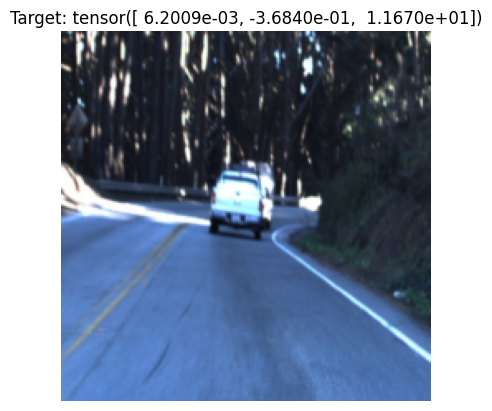

In [ ]:
# show a random pic
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

# pick from dataset
def show_random_image_from_dataset(dataset):
    # randomly find an index
    idx = random.randint(0, len(dataset) - 1)
    image, target = dataset[idx]

    # Tensor to Numpy
    image = image.numpy().transpose((1, 2, 0))  # from (C, H, W) to  (H, W, C)
    image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)  # revert normalization

    # plot img
    plt.imshow(image)
    plt.title(f"Target: {target}")
    plt.axis('off')
    plt.show()


show_random_image_from_dataset(train_dataset)


In [ ]:
import torch
import gc

# clear GPU
torch.cuda.empty_cache()

# clear RAM
gc.collect()


3782

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
from torchvision import models

# try model CNN + LSTM +fc
class CNN_LSTM_Model(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(CNN_LSTM_Model, self).__init__()

        #  load pretrained ResNet50 and drop last2
        resnet = models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])  #  (FC和AvgPool)

        #  define an avg pool
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # LSTM hidden_size =128
        self.lstm = nn.LSTM(input_size=2048+1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # fc predict steering angle
        self.fc = nn.Linear(hidden_size, 1)  # 输出单个预测值 (steering angle)

    def forward(self, x, prev_steering_angle=None):
      batch_size, seq_len, C, H, W = x.size()

      # if prev_steering_angle no input , transfer to tensor
      if prev_steering_angle is None:
          prev_steering_angle = torch.zeros(batch_size).to(x.device)

      # CNN feature extraction
      c_out = []
      for i in range(seq_len):
          cnn_out = self.cnn(x[:, i, :, :, :])  # each frame feature
          cnn_out = self.avgpool(cnn_out)       # avg pool
          cnn_out = cnn_out.view(batch_size, -1)  # flatten feature

          #  prev_steering_angle size compat with cnn_out
          prev_steering_angle_expanded = prev_steering_angle.unsqueeze(1).expand(batch_size, 1)

          # combine current cnn output with last timestep steering angle
          cnn_out = torch.cat([cnn_out, prev_steering_angle_expanded], dim=1)  # dim consistence
          c_out.append(cnn_out)

      lstm_out, _ = self.lstm(torch.stack(c_out, dim=1))  #   put sequence to lstm
      prev_steering_angle = self.fc(lstm_out[:, -1, :]).squeeze()  # current time step predic

      # return last timestep
      return prev_steering_angle

        # return all timesteps
      # return lstm_out









In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
# try ResNet CNN + FC model
class ResNet_Model(nn.Module):
    def __init__(self, hidden_size):
        super(ResNet_Model, self).__init__()

        # load pretrained ResNet50模型 and drop last 2 layers
        resnet = models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])  # drop last 2 (FC和AvgPool) layers

        # avg pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # fc layer
        self.fc = nn.Linear(2048, hidden_size)  # feature size hidden_size
        self.out = nn.Linear(hidden_size, 1)  #  output steering angle

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.size()
        prev_steering_angle = torch.zeros(batch_size).to(x.device)
        # CNN feature extraction
        cnn_features = []
        for i in range(seq_len):
            cnn_out = self.cnn(x[:, i, :, :, :])  # extract each frame feature
            cnn_out = self.avgpool(cnn_out)
            cnn_out = cnn_out.view(batch_size, -1)  # flatten
            cnn_features.append(cnn_out)

        # commerge the features
        cnn_features = torch.stack(cnn_features, dim=1)  # [batch_size, seq_len, 2048]

        # use last timestep
        final_feature = cnn_features[:, -1, :]  # [batch_size, 2048]

        # connect FC layer
        fc_out = self.fc(final_feature)
        output = self.out(fc_out)  # [batch_size, 1]

        return output




In [ ]:
# angel range
def compute_steering_angle_range(train_loader):
    max_angle = -np.inf
    min_angle = np.inf
    for _, labels in train_loader:
        steering_angles = labels[:, 0].numpy()
        max_angle = max(max_angle, np.max(steering_angles))
        min_angle = min(min_angle, np.min(steering_angles))
    return max_angle, min_angle



# train model
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, threshold=0.05):
    train_losses, train_mses, train_accs = [], [], []
    val_losses, val_mses, val_accs = [], [], []
    # compute steering angle range
    max_angle, min_angle = compute_steering_angle_range(train_loader)
    print(f"Steering Angle Range: Max = {max_angle:.4f}, Min = {min_angle:.4f}")

    #train
    for epoch in range(num_epochs):
        model.train()  # set model to train
        running_loss = 0.0
        total_samples = 0
        correct_predictions = 0  #  accuracy compute
        total_mse = 0.0  #  MSE compute

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            steering_angles = labels[:, 0].to(device).unsqueeze(1)  # [16] -> [16, 1]  # extract steering angle

            # clear grad
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)

            # loss calculate
            loss = criterion(outputs, steering_angles)

            # backward + optim
            loss.backward()
            optimizer.step()

            # compute running loss
            running_loss += loss.item() * inputs.size(0)

            # compute MSE
            mse = torch.mean((outputs - steering_angles) ** 2).item()
            total_mse += mse * inputs.size(0)

            # compute accuracy： determine whether the prediction is close to the true value by a threshold value
            predicted_angles = outputs.detach().cpu().numpy()
            true_angles = steering_angles.detach().cpu().numpy()
            correct_predictions += np.sum(np.abs(predicted_angles - true_angles) < threshold)
            total_samples += inputs.size(0)

        # avg MSE and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_mse = total_mse / len(train_loader.dataset)
        # accuracy = correct_predictions / total_samples

        train_losses.append(epoch_loss)
        train_mses.append(epoch_mse)
        # train_accs.append(accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, MSE: {epoch_mse:.4f}, Accuracy: {accuracy:.4f}')

        # validation
        val_loss, val_mse, val_accuracy = validate_model(model, criterion, val_loader, threshold)
        val_losses.append(val_loss)
        val_mses.append(val_mse)
        val_accs.append(val_accuracy)

    plot_training_validation_curves(train_losses, val_losses, train_accs, val_accs, train_mses, val_mses)
     # compute and ouput global MSE
    global_train_mse = np.mean(train_mses)
    global_val_mse = np.mean(val_mses)

    print(f'Global Train MSE: {global_train_mse:.4f}')
    print(f'Global Train MSE: {global_val_mse:.4f}')
    print(f'MSE as percentage of angle range: {global_train_mse / (max_angle - min_angle):.4%}')
    print(f'MSE as percentage of angle range: {global_val_mse / (max_angle - min_angle):.4%}')
# validation function
def validate_model(model, criterion, dataloader, threshold=0.05):
    model.eval()  #
    running_loss = 0.0
    total_samples = 0
    correct_predictions = 0  #
    total_mse = 0.0  #

    with torch.no_grad():  #
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            steering_angles = labels[:, 0].to(device).unsqueeze(1)  # [16] -> [16, 1]  # 只提取 steering angle

            # forward
            outputs = model(inputs)

            #
            loss = criterion(outputs, steering_angles)

            #  running loss
            running_loss += loss.item() * inputs.size(0)

            #  MSE
            mse = torch.mean((outputs - steering_angles) ** 2).item()
            total_mse += mse * inputs.size(0)

            #  determine the prediction is close to the truth value
            predicted_angles = outputs.detach().cpu().numpy()
            true_angles = steering_angles.detach().cpu().numpy()
            correct_predictions += np.sum(np.abs(predicted_angles - true_angles) < threshold)
            total_samples += inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_mse = total_mse / len(dataloader.dataset)
    # accuracy = correct_predictions / total_samples

    print(f'Validation Loss: {epoch_loss:.4f}, MSE: {epoch_mse:.4f}')

    return epoch_loss, epoch_mse

# plot mse and loss
def plot_training_validation_curves(train_losses, val_losses, train_accs, val_accs, train_mses, val_mses):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    ax[0].plot(train_losses, label='Train Loss')
    ax[0].plot(val_losses, label='Validation Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # ax[1].plot(train_accs, label='Train Accuracy')
    # ax[1].plot(val_accs, label='Validation Accuracy')
    # ax[1].set_title('Accuracy')
    # ax[1].set_xlabel('Epoch')
    # ax[1].set_ylabel('Accuracy')
    # ax[1].legend()

    ax[2].plot(train_mses, label='Train MSE')
    ax[2].plot(val_mses, label='Validation MSE')
    ax[2].set_title('MSE')
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('MSE')
    ax[2].legend()

    plt.tight_layout()
    plt.show()

# # init parameter and model
# hidden_size = 256
# # model = ResNet_Model(hidden_size=hidden_size).to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# tran
# train_model(model, criterion, optimizer, small_train_dataloader, small_val_dataloader, num_epochs=5)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s]


Steering Angle Range: Max = 1.7435, Min = -1.1711
Epoch 1/10, Train Loss: 0.0441, MSE: 0.0441, Accuracy: 0.2221
Validation Loss: 0.1193, MSE: 0.1193, Accuracy: 0.2658
Epoch 2/10, Train Loss: 0.0189, MSE: 0.0189, Accuracy: 0.3229
Validation Loss: 0.0751, MSE: 0.0751, Accuracy: 0.1038
Epoch 3/10, Train Loss: 0.0148, MSE: 0.0148, Accuracy: 0.3812
Validation Loss: 0.0925, MSE: 0.0925, Accuracy: 0.2304
Epoch 4/10, Train Loss: 0.0074, MSE: 0.0074, Accuracy: 0.5260
Validation Loss: 0.0447, MSE: 0.0447, Accuracy: 0.3114
Epoch 5/10, Train Loss: 0.0057, MSE: 0.0057, Accuracy: 0.5805
Validation Loss: 0.0653, MSE: 0.0653, Accuracy: 0.3494
Epoch 6/10, Train Loss: 0.0068, MSE: 0.0068, Accuracy: 0.5279
Validation Loss: 0.0517, MSE: 0.0517, Accuracy: 0.3063
Epoch 7/10, Train Loss: 0.0038, MSE: 0.0038, Accuracy: 0.6652
Validation Loss: 0.0591, MSE: 0.0591, Accuracy: 0.2962
Epoch 8/10, Train Loss: 0.0042, MSE: 0.0042, Accuracy: 0.6288
Validation Loss: 0.0838, MSE: 0.0838, Accuracy: 0.3038
Epoch 9/10, Tr

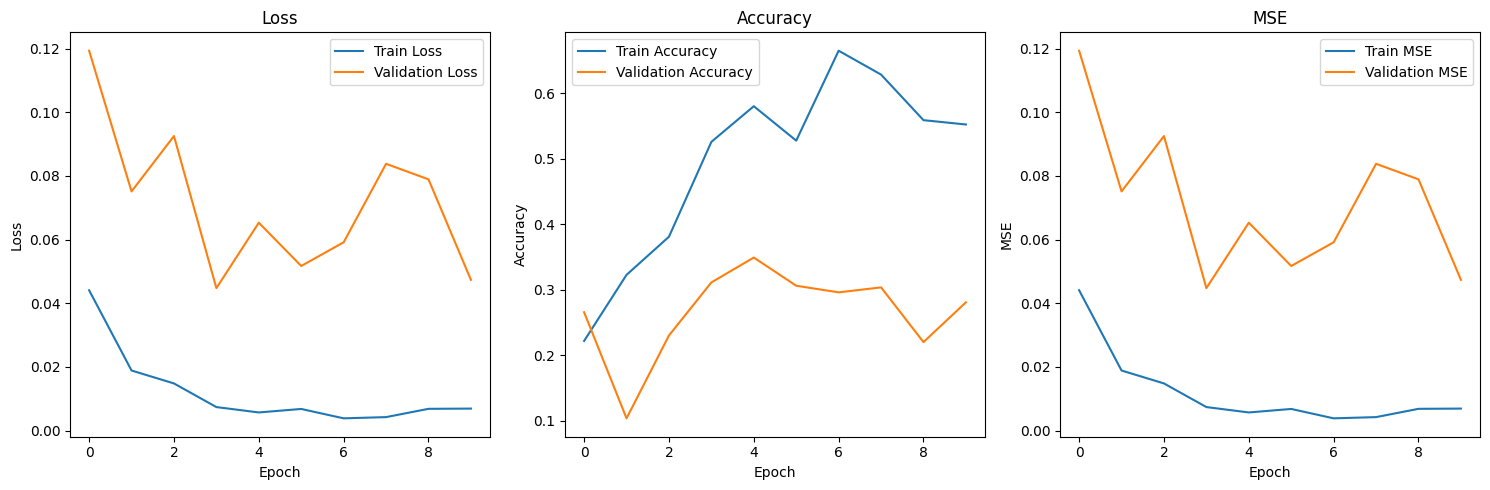

Global Train MSE: 0.0119
Global Train MSE: 0.0718
MSE as percentage of angle range: 0.4099%
MSE as percentage of angle range: 2.4631%


In [ ]:
# train resnet+fc model on small dataset to check performance , "accuracy" item should not be cared, mse is the indicator

hidden_size = 128
num_layers = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn(16, 5, 3, 224, 224).to(device)  # resize (224x224)

target = torch.randn(16, 1).to(device)  # randm target (steering angle) transfer to GPU
model_resnet_fc= ResNet_Model(hidden_size=hidden_size).to(device)
# loss function and loss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_resnet_fc.parameters(), lr=0.0001,weight_decay=1e-4)
train_model(model_resnet_fc, criterion, optimizer, small_train_dataloader, small_val_dataloader, num_epochs=10)

In [ ]:
import torch
import os

# confirm dir
model_dir = "/content/drive/MyDrive/model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# save model state dict
model_path = os.path.join(model_dir, "resnet_model_fc.pth")
torch.save(model_resnet_fc.state_dict(), model_path)
print(f"Model saved to {model_path}")


In [ ]:
# # call model
# # init model
# model_resnet_fc = ResNet_Model(hidden_size=hidden_size).to(device)

# # load model
# model_resnet_fc.load_state_dict(torch.load(model_path))
# model_resnet_fc.eval()  # eval mode
# model_resnet_fc.train()  # or train mode


In [ ]:
train_model(model_resnet_fc,criterion, optimizer,train_loader, val_loader, num_epochs=10)

Steering Angle Range: Max = 1.9007, Min = -1.2338


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Train Loss: 0.0790, MSE: 0.0790, Accuracy: 2.1269


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation Loss: 0.2351, MSE: 0.2351, Accuracy: 1.4278
Epoch 2/10, Train Loss: 0.0724, MSE: 0.0724, Accuracy: 2.4366
Validation Loss: 0.2394, MSE: 0.2394, Accuracy: 1.3342
Epoch 3/10, Train Loss: 0.0724, MSE: 0.0724, Accuracy: 2.3636
Validation Loss: 0.2359, MSE: 0.2359, Accuracy: 1.4506
Epoch 4/10, Train Loss: 0.0696, MSE: 0.0696, Accuracy: 2.2988
Validation Loss: 0.2353, MSE: 0.2353, Accuracy: 1.5089
Epoch 5/10, Train Loss: 0.0679, MSE: 0.0679, Accuracy: 2.1624
Validation Loss: 0.2348, MSE: 0.2348, Accuracy: 1.1848
Epoch 6/10, Train Loss: 0.0676, MSE: 0.0676, Accuracy: 2.1790
Validation Loss: 0.2335, MSE: 0.2335, Accuracy: 1.4557
Epoch 7/10, Train Loss: 0.0676, MSE: 0.0676, Accuracy: 2.3286
Validation Loss: 0.2364, MSE: 0.2364, Accuracy: 1.4810
Epoch 8/10, Train Loss: 0.0683, MSE: 0.0683, Accuracy: 2.1847
Validation Loss: 0.2314, MSE: 0.2314, Accuracy: 1.2101
Epoch 9/10, Train Loss: 0.0676, MSE: 0.0676, Accuracy: 2.2197
Validation Loss: 0.2348, MSE: 0.2348, Accuracy: 1.4380
Epoch 10/

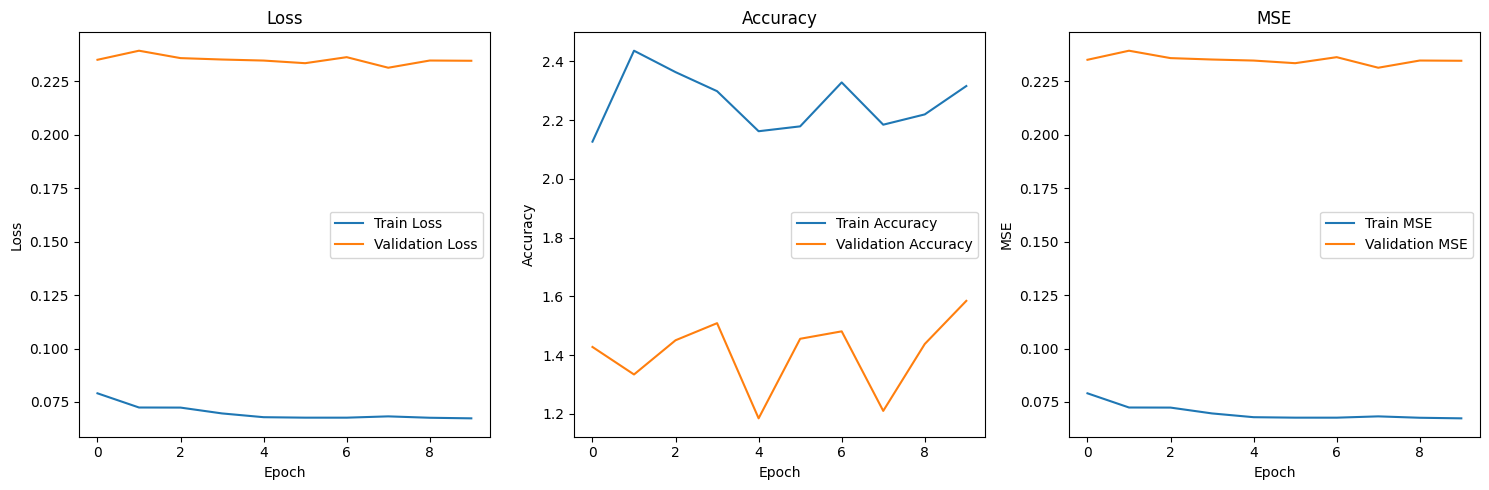

Global Train MSE: 0.0700
Global Train MSE: 0.2351
MSE as percentage of angle range: 2.2324%
MSE as percentage of angle range: 7.5012%


In [14]:
#设置 resnet_cnn_lstm model
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_size = 128
num_layers = 1
#lstm model
model_cnn_lstm = CNN_LSTM_Model(hidden_size=hidden_size, num_layers=num_layers).to(device)

# loss function and MSE
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_cnn_lstm.parameters(), lr=0.0001,weight_decay=1e-4)

# resize
x = torch.randn(16, 5, 3, 224, 224).to(device)  # resize (224x224)

target = torch.randn(16, 1).to(device)  # rand (steering angle) to GPU
prev_steering_angle = torch.zeros(16).to(device)  # initialize steering angel to GPU

# output and loss
outputs = model_cnn_lstm(x, prev_steering_angle)
loss = criterion(outputs, target)

# backward and optim
loss.backward()
optimizer.step()

#train on small train and val
train_model(model_cnn_lstm, criterion, optimizer, small_train_dataloader, small_val_dataloader, num_epochs=10)


# #train on full train and val dataloader
# train_model(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs=5)

In [ ]:
#train resnet LSTM model on small dataset

# model_resnet_lstm = Resnet_LSTM_Model(hidden_size=hidden_size, num_layers=num_layers).to(device)
# train_model(model_resnet_lstm, criterion, optimizer, small_train_dataloader, small_val_dataloader, num_epochs=10)

In [ ]:
#if small train works well, train model_cnn_lstm on full dataset
train_model(model_cnn_lstm, criterion, optimizer, train_loader, val_loader, num_epochs=10)


Steering Angle Range: Max = 1.9033, Min = -1.2444
Epoch 1/10, Train Loss: 0.0644, MSE: 0.0644, Accuracy: 2.2777


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation Loss: 0.2329, MSE: 0.2329, Accuracy: 1.4788
Epoch 2/10, Train Loss: 0.0648, MSE: 0.0648, Accuracy: 2.3200
Validation Loss: 0.2380, MSE: 0.2380, Accuracy: 1.1840


In [15]:
import torch
import os

# confirm directory
model_dir = "/content/drive/MyDrive/model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# save model state dict
model_path = os.path.join(model_dir, "model_cnn_lstm.pth")
torch.save(model_cnn_lstm.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to /content/drive/MyDrive/model/model_cnn_lstm.pth


In [ ]:
# evaluation
import torch

def evaluate_model(model, test_dataloader, criterion, device='cuda'):
    model.eval()  # set to evaluation
    test_loss = 0.0
    total_samples = 0
    total_mse = 0.0  # record MSE

    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward to predict
            outputs = model(inputs)

            # compute loss
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)

            # compute MSE
            mse = torch.mean((outputs - targets) ** 2).item()
            total_mse += mse * inputs.size(0)

            total_samples += inputs.size(0)

    #  avg MSE and avg loss
    avg_test_loss = test_loss / total_samples
    avg_mse = total_mse / total_samples

    print(f"Test Loss: {avg_test_loss:.4f}, Test MSE: {avg_mse:.4f}")

    return avg_test_loss, avg_mse

# call eval function
test_loss, test_mse = evaluate_model(model_cnn_lstm, test_loader, criterion, device)


In [ ]:
#if small train works well, train resnet LSTM model on full dataset
# train_model(model_resnet_lstm,criterion, optimizer, train_dataloader, val_dataloader, num_epochs=10)

Epoch 1/5, Train Loss: 0.0635, MSE: 0.0635, Accuracy: 3.3073
Validation Loss: 0.2460, MSE: 0.2460, Accuracy: 1.2734
Epoch 2/5, Train Loss: 0.0636, MSE: 0.0636, Accuracy: 3.3030
Validation Loss: 0.2460, MSE: 0.2460, Accuracy: 1.2709
Epoch 3/5, Train Loss: 0.0636, MSE: 0.0636, Accuracy: 3.1979
Validation Loss: 0.2456, MSE: 0.2456, Accuracy: 1.2456
Epoch 4/5, Train Loss: 0.0635, MSE: 0.0635, Accuracy: 3.3082
Validation Loss: 0.2440, MSE: 0.2440, Accuracy: 1.4658
Epoch 5/5, Train Loss: 0.0635, MSE: 0.0635, Accuracy: 3.3381
Validation Loss: 0.2451, MSE: 0.2451, Accuracy: 1.3139


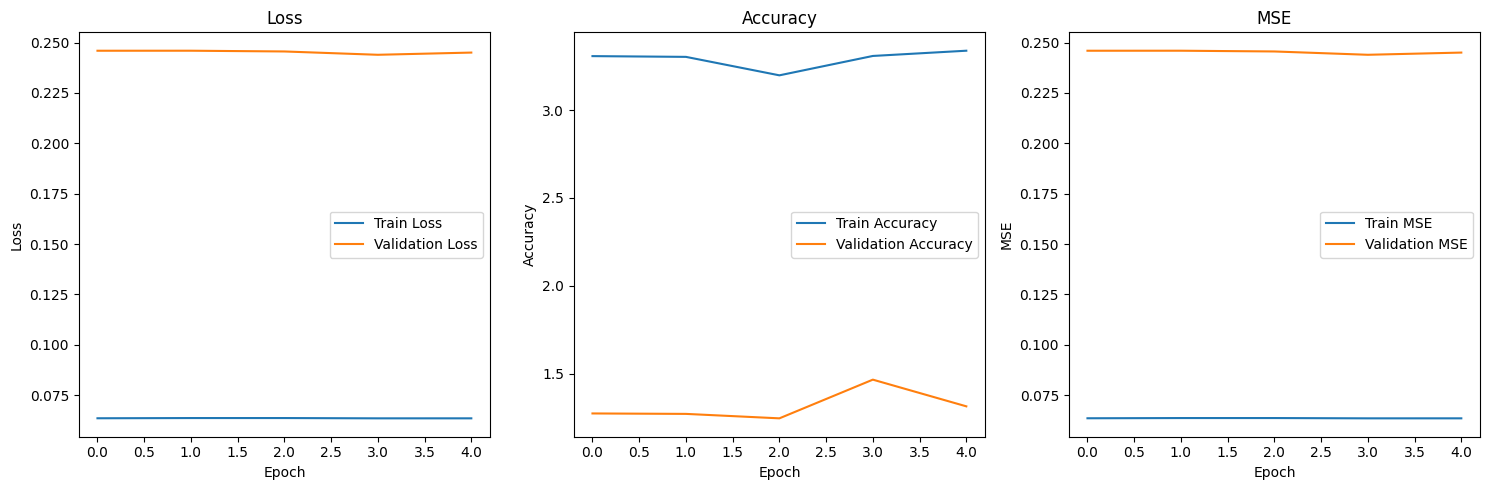

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay= 1e-4)
train_model(model, criterion, optimizer, small_train_dataloader, small_val_dataloader, num_epochs=5)
#CNN+LSTM

In [ ]:
x.size()

torch.Size([16, 5, 3, 224, 224])